$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\ketbra}[2]{| #1\rangle \langle #2|} $
$ \newcommand{\tr}{{\rm tr}} $
$ \newcommand{\i}{{\color{blue} i}} $
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\V}{{\cal V}} $
$ \newcommand{\bn}{{\bf n}} $

# 2. Single-qubit driving

The pulse-level implementation of some of the most common native gates will be explored, including the physical meaning of qubit driving, the different techniques and features available in Qmio using the OpenPulse grammar, and illustrative examples of gate calibration and single-qubit operations based on Rabi oscillations.

## 2.1. Qubit pulse control

Now that we understand how a qubit system -such as a transmon- is physically described, we can move into action and learn how to interact with it to change its state and apply transformations equivalent to ideal quantum gates. The physical implementation of this driving depends on the specific hardware -for example, lasers for NV-centers- but in general, it consists of applying pulses to add energy to the system. For example, in supeconducting qubits like transmons, the control is performed by coupling the system to a microwave driving line, which feeds energy to the qubit in a manner analogous to a forced oscillator.


<br>
<div style="text-align: center;">
    <img src="./media/driving.png" width="420">
</div>
<br>


Interpreting these pulses as photons, the general idea is to apply them at the resonance frequency of the qubit, which corresponds to the transition frequency of $\ket{0}\leftrightarrow\ket{1}$. As a result, either excitation -via absorption- or relaxation -via stimulated emission- can happen, depending on the qubit's state: 

- If the qubit is in $\ket{0}$, only absorption can occur, exciting the system to $\ket{1}$. 

- If the qubit is in $\ket{1}$, the applied photons can't promote the system to a higher state because of the transmon's anharmonicity. In this case, the only possible effect is stimulated emission (similar to what occurs in lasers), which relaxes de qubit back to $\ket{0}$. 

When a continuous pulse of photons is applied, the populations of the states oscillate with time. This behaviour in known as **Rabi oscillations**. These oscillations are key to implementing quantum gates, because their period can be controlled by adjusting the pulse amplitude and duration. For example, by calibrating the pulse duration to completetly populate $\ket{1}$ starting from $\ket{0}$, one effectively implements an X gate.

#### The pendulum analogy
A natural question arises in this setup: **If the qubit is an oscillator, why does its energy sometimes decrease even though we are always adding energy?** The answer lies in the transmon's anharmonicity. If the qubit were a purely harmonic oscillator, driving it at the resonance frequency would lead to unbounded excitation, promoting the system indefinitely through higher energy states -just as in a classical forced harmonic oscillator. The anharmonicity of the transmon limits the population of the oscillator states, as only the $\ket{0}\leftrightarrow\ket{1}$ transition is allowed.<br>
<br>
It may not still be clear how the anharmonicity is responsible of this effect in transmons, fortunatetly, there is a classical system that presents a similar behaviour that could help us visualize it: the **forced non-linear pendulum**. Bringing our attention to the classical pendulum, when the oscillations are small enough, we can model it as an harmonic oscillator with a resonance frequency $\left(g/L\right)$, but when the oscillations grow in magnitude, the non-linear terms become relevant and the resonance frequency is shifted. If an oscillating force -pulse- is applied on the pendulum at the resonance frequency of its harmonic regime, the energy of the system will be bounded -meaning that it will reach a maximum amplitude- because the frequency will be detuned by the non-linear terms.<br>
<br>

Although they are not physically equivalent systems, we can make the following analogy: when the pendulum has the minimum potential energy (no amplitude) we say that it's on the state $\ket{0}$, and it is in state $\ket{1}$ when it has the maximum aplitude. Obviously, for the classical pendulum there is an infinite number of energy eigenstates between those two, but we can understand these intermidiate states as the superposition of $\ket{0}$ and $\ket{1}$. The observed amplitude from the oscillation can be interpreted as the mean value, which depends on the populations of both states. The following video is a representation of this system with a constant amplitude pulse driving, keep in mind that this simulation is for the classical ecuations of the forced non-linear pendulum:

<br>
<br>
<div style="text-align: center;">
  <video width="720" height="480" controls>
    <source src="./media/DrivenPendulum.mp4" type="video/mp4">
    Tu navegador no soporta el video.
  </video>
</div>
<br>
<br>

As you can see, the system starts with zero energy $\left(\ket{0}\right)$, and, at first, the incoming pulse produces the excitation, promoting the state and increasing the mean energy. This is analogous to the state $\ket{1}$ being populated by absorption. After some time, we arrive to the maximum amplitude $\left(\ket{1}\right)$, from where the mean energy begins to decrease again. This is analogous to the relaxation of the system by stimulated emission. Finally, the characteristic Rabi-like periodic behaviour appears as the pulse continues to being applied.<br>
<br>

As seen before, the application of a quantum gate, for example an X gate, can be performed by choosing the appropiate duration of the pulse -depending also on its amplitude- that leaves the system totally excited. We can also visualize this with the forced pendulum, where we only need to stop applying the pulse when the oscillator reaches its maximum amplitude. On the next video, you can see that the systems starts at the minimum of energy -representing state $\ket{0}$- and when the pulse stops, it leaves the system in the maximum energy that could be achieved by the resonance -representing state $\ket{1}$.

<br>
<br>
<div style="text-align: center;">
  <video width="720" height="480" controls>
    <source src="./media/XGatePendulum.mp4" type="video/mp4">
    Tu navegador no soporta el video.
  </video>
</div>
<br>
<br

As settled before, there is no physical equivalence between these two systems -nothing quantum is going on with the pendulum- but in both cases a non-linear term in the energy spectrum breaks the unbounded resonance and a periodic response appears.

## 2.2. Pulse-level quantum gates

We have seen why pulses produce Rabi oscillations in qubits, but we need to have some physical model to be able to design these pulses for a gate implementations. In this section, first we'll see step-by-step the characterization of pulses, and how they determine the Rabi oscillation period. Then, we'll learn how to implement these pulses with OpenPulse and observe Rabi oscillations on real quantum hardware.

#### Qubit driving in the rotating frame

The driving coupled line can be expressed as follows:
$$H_d=-i\Omega V_d(t)(a-a^\dagger),$$
where $\Omega$ is some constant that depends con the capacitances of the superconducting circuit, $V_d(t)$ is the time-dependent potential that characterizes the pulse -this is the signal we have control over- and $a\left(a^\dagger\right)$ are the anihilation(creation) operators for the qubit oscillator. This operators, truncated for a two level system, cab be expressed as:
$$H_d=\Omega V_d(t)\sigma_y,$$
where $\sigma_y$ is the Pauli operator. The complete qubit-driving system has the following shape:
$$H=H_0+H_d=-\frac{\hbar\omega_q}{2}\sigma_z+\Omega V_d(t)\sigma_y.$$
This Hamiltonian will determine the time evolution of the system, due to both the intrinsic evolution of the oscillator and the driving. We have seen that the part corresponding to the intrinsic evolution can be easily reverted by working on the rotation frame of the qubit. When applying the corresponding transformations, the Hamiltonian of the qubit driving is:
$$\tilde{H}=\Omega V_d(t) \bigl[\cos(\omega_q t)\sigma_y-\sin(\omega_q t)\sigma_x\bigl]. $$

#### Potential characterization
The part of the pulse that we have control over is the oscillating potential that generates it: $V_d(t)$. The shape of this potential can be described by a **constant amplitude** $\left(V_0\right)$, an **amplitude envelope** $\left(s(t)\right)$ and the oscillatory component with a **driving frequency** $\left(\omega_d\right)$ and an **initial phase** $\left(\phi\right)$:
$$V_d(t)=V_0\cdot s(t)\cdot \sin(\omega_d t + \phi).$$
Nevertheless, it's usual to decompose oscillatory part in the *in-phase* $\mathcal{I}$ and *out-of-phase* $\mathcal{Q}$ terms:
$$V_d(t)=V_0s(t)\left[\mathcal{I}\sin(\omega_d t) + \mathcal{Q}\cos(\omega_d t)\right],$$
where: 
$$\begin{align*}
\mathcal{I}=\cos\phi,\quad
\mathcal{Q}=\sin\phi.
\end{align*}$$
By inserting this expression on the rotating-frame Hamiltonian, we arrive -after eliminating some high frequency terms by the rotating wave approximation- to the following effective Hamiltonian:
$$\begin{align*}
\tilde{H}=\frac{\Omega V_0}{2}s(t)\Bigl[-\left(\mathcal{I}\cos(\delta\omega t) + \mathcal{Q}\sin(\delta\omega t)\right)\sigma_x+\left(-\mathcal{I}\sin(\delta\omega t) + \mathcal{Q}\cos(\delta\omega t)\right)\sigma_y\Bigl],
\end{align*}$$
where $\delta\omega=\omega_q-\omega_d$ is the detuning of the driving frequency from the resonance of the qubit. 

####

#### Rabi oscillations

When we drive the qubit at resonance -$\omega_d=\omega_q$- the expression from before is reduced to the much simpler:
$$\tilde{H}=\frac{\Omega V_0}{2}s(t)\Bigl(-\mathcal{I}\sigma_x+\mathcal{Q}\sigma_y\Bigl).$$
In general, this expression is the only thing we need to design the quantum gates. From here, we can choose different amplitudes $\left(V_0\right)$ or waveforms $\left(s(t)\right)$ for the pulse, in order to control the dynamics of the driving. <br>
<br>

For example, let's work with the amplitude envelope $s(t)=1$ -also called **constant** pulse- and no initial phase, meaning that $\mathcal{I}=1$ and $\mathcal{Q}=0$. The Hamiltonian for this particular case is:
$$\tilde{H}=-\frac{\Omega V_0}{2}s(t)\sigma_x,$$
that determines an unitary evolution of the system that corresponds to a rotation over the $X$ axis of the Bloch sphere, an $R_X$ gate:
$$U(t)=\exp\left(-i\frac{\Omega V_0}{2\hbar}t\cdot\sigma_x\right)=\exp\left(-i\frac{\Omega_R}{2}t\cdot\sigma_x\right)=R_X\left(\Omega_R t\right).$$
In other words, we have implemented a parametrized rotation on the qubit state that depends on some tunnable parameters. <br>
<br>

This rotation is the physical representation of the **Rabi oscillation** we saw before. If we compute the propability of the computational states over time -starting from $\ket{0}$- we get the expected oscillatory behaviour between them:

$$\begin{align*}
P_0(t)=\frac{1}{2}\left(1+\cos\left(\Omega_R t\right)\right),\quad
P_1(t)=\frac{1}{2}\left(1-\cos\left(\Omega_R t\right)\right).
\end{align*}$$


<br>
<div style="text-align: center;">
    <img src="./media/RabiOscillationGraph.png" width="720">
</div>
<br>



If we wanted to apply an X gate -disregarding global phases- we would just need to choose the appropiate pulse, so the Rabi oscillation stops when the desired populations are found:

$$\Omega_R T = \pi\Rightarrow V_0 T = \frac{\hbar\pi}{\Omega},$$

where $V_0$ -amplitude- and $T$ -duration- are the parameters of the pulse we have control over, and the rest depend on the system and are usually not known. In practice, we have to equivalent options:

- Fix the pulse amplitude $V_0$ and calibrate the appropiate duration by sweeping $T$.

- Fix the pulse duration $T$ and calibrate the appropiate amplitude by sweeping $V_0$.

## 2.3. Rabi oscillations with OpenPulse

Now that we have the theory, let's start with the hands-on introduction to its implementation with OpenPulse. The first step will be setting up the basic instructions for custom pulse configuration, then, we will develop an experiment to measure this Rabi oscillations in Qmio.

#### Applying a custom pulse

Below there is a basic OpenPulse instruction block for a custom pulse, that recreates the situation described in last section:

```
OPENQASM 3;
defcalgrammar "openpulse";
    
cal {
    extern frame q8_drive;
    waveform wf = constant(1000dt, 0.15);
}

defcal custom_pulse $8{
    play(q8_drive, wf);
}

custom_pulse $8;
measure $8;
```

Let's break it down step-by-step:

- ```OPENQASM 3```: specifies to the backend interpreter the language the instruction block uses.

- ```defcalgrammar "openpulse"```: declares the grammar used in the **calibration blocks**: ```cal``` and ```defcal```.

- ```cal``` blocks: used to access all the relevant system information, such as accessing qubit frames, declaring pulse shapes or other variables used in ```defcal``` blocks.

- ```defcal``` blocks: implement the custom pulse schedule, they are targeted to specific qubits and can be invoked at any time -after its declaration- on the main instruction code.

- ```extern frame q8_drive```: imports the frame of the **physical** qubit 8, including its resonant frequency from the calibrations.

- ```waveform wf = constant(900dt, 0.15)```: defines a ```waveform``` type variable, which contains the information for the **amplitude**, **duration** and **amplitude envelope** of the pulse. This is where we can configure our pulse and change its effect. In this case, the waveform is constant $\left(s(t)=1\right)$ with a duration fo 900 time units -for Qmio $dt=0.5$ns- and an amplitude of 0.15 -limited between 0.0 and 1.0- that recreates the pulse described in laste section for some arbitrary parameters.

- ```play(q8_drive, wf)```: used to send the pulse instruction to the qubit, specifying its frame of effect and waveform. Notice that the driving frequency is set by the chosen frame, in this case it corresponds to the resonance frequency of qubit 21, as we directly imported it from calibrations. 

- ```custom_pulse $8```: invokes the custom pulse instructions declared in the ```decal```.

- ```measure $8```: invokes a default measurement instruction determined by the hardware provider, it returns a real value that allows to compute the discriminated binary output.


This instructions implement a constant envelope pulse for some arbitrary duration and amplitude equivalent to the situation we studied before. Keep in mind that by seting some duration, we are only seeing one point in time of the Rabi oscillation, and as we have no yet calibrated the pulse, it may not be the one that totally inverts the populations (the X gate).<br> 
<br>

Let's run this setup just to see how to interact with this instruction blocks in Python. First, we import the required libraries -remember that you need to set your Qmio workspace beforehand:

In [1]:
from qmio import QmioRuntimeService
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We now define the OpenPulse instruction block inside a string:

In [2]:
instruction = '''
OPENQASM 3;
defcalgrammar "openpulse";
    
cal {
    extern frame q8_drive;
    waveform wf = constant(900dt, 0.15);
}

defcal custom_pulse $8{
    play(q8_drive, wf);
}

custom_pulse $8;
measure $8;
'''

Now we instantiate the QmioRuntimeService and run the instructions on Qmio's QPU, this is the recommended used to be able to debug errors in the instructions:

In [3]:
service = QmioRuntimeService()
shots = 1000                                                                        # Number of repetitions for the instructions

with service.backend(name = "qpu") as backend:                                      # Get the Qmio QPU backend
    res = backend.run(circuit = instruction, shots = shots, res_format = 'raw')     # Send the instructions and retrieve results
    try :
        res = res["results"].reshape((shots,))                                      # Access numerical values from the job result
    except :
        print(res)                                                                  # Print output message in case of error during instruction execution

Waiting for resources


Now we have the output measurement for the qubit state **after the pulse application**. Let's understand what this output means by plotting its histogram:

(array([ 3.,  3.,  8., 12., 12., 24., 32., 39., 56., 39., 47., 38., 36.,
        23., 31., 30., 46., 46., 48., 73., 85., 75., 67., 45., 31., 25.,
        18.,  5.,  1.,  2.]),
 array([-2.76682351, -2.57896844, -2.39111338, -2.20325831, -2.01540325,
        -1.82754818, -1.63969312, -1.45183805, -1.26398299, -1.07612793,
        -0.88827286, -0.7004178 , -0.51256273, -0.32470767, -0.1368526 ,
         0.05100246,  0.23885753,  0.42671259,  0.61456766,  0.80242272,
         0.99027779,  1.17813285,  1.36598792,  1.55384298,  1.74169805,
         1.92955311,  2.11740818,  2.30526324,  2.49311831,  2.68097337,
         2.86882844]),
 <BarContainer object of 30 artists>)

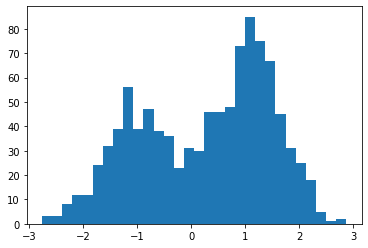

In [4]:
plt.hist(res, bins = 30)

In each execution of the instructions, one real value is retrieved -usually in [-3,3]- and by repetition we get a distribution that depends on the qubit state in the moment of the measurement. These values are generally distributed as asymetric gaussians around some value:

- Positive for measurements from the state $\ket{0}$.

- Negative for measurements from the state $\ket{1}$.

This two distributions may present a great overlapping in values near 0, that increases the error for the classification. What we are seing on the output for this instruction is the two distributions at the same time, with different populations. This happens because the pulse has changed the qubit state to a superposition of $\ket{0}$ and $\ket{1}$, so in each shot of the execution we have a probability to measure each of these states, as expected for an arbitrary $R_X$ rotation.We can retrieve the population for each state by just counting the clasificated bits measured over all the executions:




In [5]:
p1 = len(np.where(res<0)[0])/shots
p0 = 1 - p1
print(f'P0 = {p0:0.3f}')
print(f'P1 = {p1:0.3f}')

P0 = 0.606
P1 = 0.394


#### Observing Rabi oscillations

Unfortunatetly, we can only measure once per execution, so in order to observe the Rabi oscillation we need to build a specific instruction for each amplitude. This can be achieved by sweeping the amplitude of the applied pulse, executing a different instruction for each. There are many ways to implement this interaction with Python, the following was chosen to be very accessible to change the parameters of the instruction:

In [6]:
qubit = 8
duration = 500

def build_instruction(_amp):
    _instruction = f'''
    OPENQASM 3;
    defcalgrammar "openpulse";
        
    cal {{
        extern frame q{qubit}_drive;
        waveform wf = constant({duration}dt, {_amp});
    }}

    defcal custom_pulse ${qubit}{{
        play(q{qubit}_drive, wf);
    }}

    custom_pulse ${qubit};
    measure ${qubit};
    '''
    return _instruction

def run_instruction(_backend, _instruction, _shots):  
        _res = _backend.run(circuit = _instruction, shots = _shots, res_format = 'raw')     
        try :
            return _res["results"].reshape((_shots,))                                      
        except :
            print(_res) 

def plot_data(_amps, _p1):
    plt.plot(_amps, _p1)
    plt.xlabel(r'Amplitude')
    plt.ylabel(r'$P_1$')

Waiting for resources


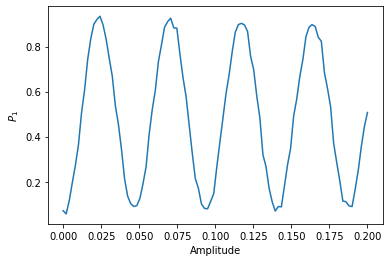

In [7]:
amps = np.linspace(0.0, 0.2, 100)
shots = 700

p1 = []

with service.backend(name = "qpu") as backend:  
    for a in amps:
        instruction = build_instruction(a)
        res = run_instruction(backend, instruction, shots)
        p1.append(len(np.where(res<0)[0])/shots)

plot_data(amps, p1)

In the image we can clearly see the oscillations of the populations when we change the amplitude of the pulse, a calibrated X gate would consist in applying a pulse with the fixed duration -in this case 500dt- and the amplitude where the maximum population for $\ket{1}$ was found.

## 2.4. Pulse waveforms

## 2.5. Gate calibration examples